In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

import numpyro
import math
import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt

from jax import random
from numpyro.infer import MCMC, NUTS

import numpyro.distributions as dist

import arviz as az

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Construction of the input signal and pointing matrix

In [13]:
# N_d: number of detectors; N_r: number of rows of pixels; N_t: number of times data is detected by each detector; N_p: number of pixels
# signal: data of signal (which in this case is modeled to be a sine function in each pixel)
# P: pointing matrix block
# PM: pointing matrix

N_d, N_r, N_t, N_p = 30, 3, 150 * 10, 10

# original signal
# signal_org = [[0] * N_p for _ in range(N_d)]
# for i in range(N_d):
#     for j in range(N_p):
#         # signal_org[i][j] = 5 * (i + 1) * j * math.sin((2 * math.pi / N_p) * j)
#         signal_org[i][j] = 10 * (i + 1) * math.sin((2 * math.pi / N_p) * j)
# signal_org = np.array(signal_org)
# print(np.shape(signal_org))
signal = np.random.uniform(low=5, high=30, size=N_p*N_r)

# converted signal array
#bsignal = signal_org.reshape(N_d * N_p,) 
print(np.shape(signal))

(30,)


In [3]:
# plt.imshow(signal_org)

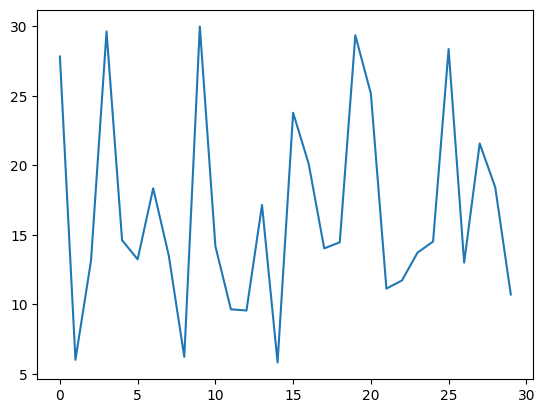

In [14]:
plt.plot(signal)
plt.show()

# plt.plot(signal_2)
# plt.show()

In [15]:
# pointing matrix block: the pointing matrix if there were only one detector (which will not be used)

P = [[0] * N_p for _ in range(N_t)]
for row in range(N_t):
    for col in range(N_p):
        if ((row / 150) // (10 / 10) == col):
            P[row][col] = 1
P = np.array(P)

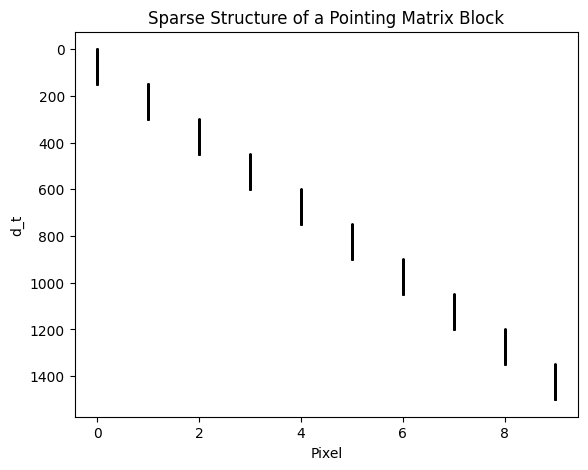

In [16]:
rows, cols = np.where(P == 1)

plt.figure(figsize=(6.5,5))
plt.scatter(cols, rows, s=1, color='black')
plt.gca().invert_yaxis()
plt.xlabel('Pixel')
plt.ylabel('d_t')
plt.title('Sparse Structure of a Pointing Matrix Block')
plt.show()

In [17]:
# pointing matrix (which will not be used)

from scipy.sparse import block_diag

blocks = [P, P, P]

PM = block_diag(blocks, format='csr')

print(np.shape(PM))

(4500, 30)


In [18]:
print(type(PM))

<class 'scipy.sparse._csr.csr_matrix'>


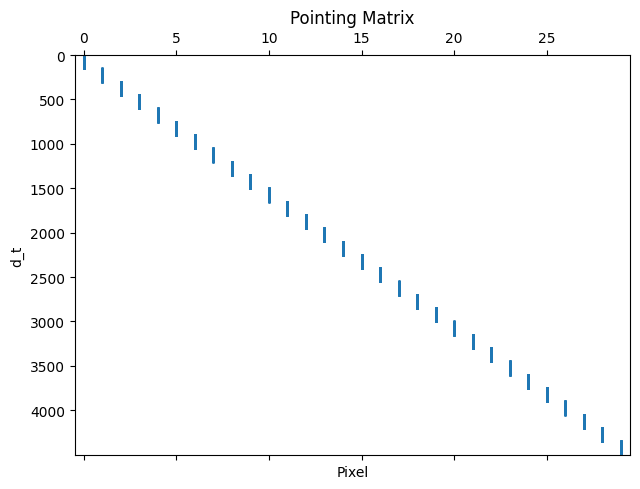

In [19]:
plt.figure(figsize=(6.5,5))
plt.spy(PM, markersize=1)
plt.title("Pointing Matrix")
plt.xlabel("Pixel")
plt.ylabel("d_t")
plt.gca().set_aspect('auto')        # default is 'equal', which may squash it
plt.tight_layout()                  # avoid text overlap
plt.show()

In [20]:
# P_encoded: the encoded pointing matrix

P_encoded = list()
for i in range(N_r):
    for row in range(N_t):
        for col in range(N_p):
            if ((row / 150) // (10 / 10) == col):
                P_encoded.append(col + i * N_p)
            
P_encoded = np.array(P_encoded)

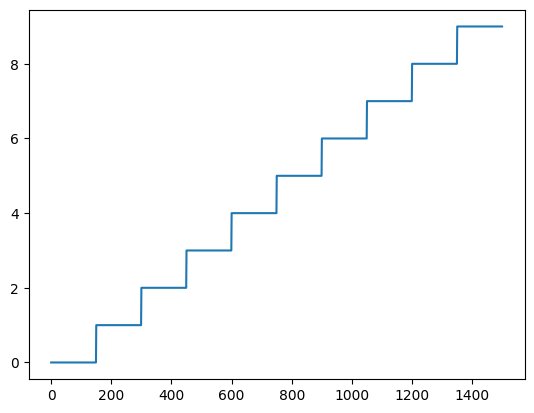

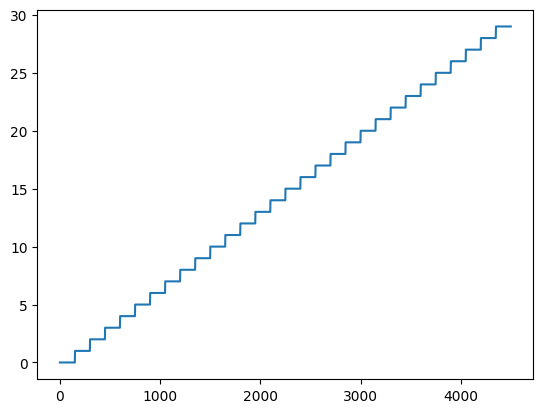

In [21]:
# check P_encoded

plt.plot(P_encoded[:N_t])
plt.show()

plt.plot(P_encoded)
plt.show()

In [24]:
input = signal[P_encoded]
# input_2 = signal_2[P_encoded]
print(np.shape(input))

(4500,)


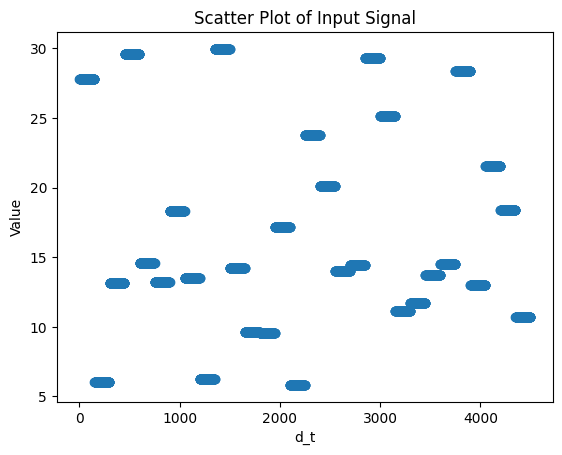

In [ ]:
# Scatter Plot of Input Signals

plt.scatter(range(len(input)), input)
plt.xlabel("d_t")
plt.ylabel("Value")
plt.title("Scatter Plot of Input Signal")
plt.show()

Creating the Data: Add White, Gaussian Noise to Input Signal

In [27]:
# Creating noisy data

noise_1 = np.random.randn(N_t*N_r) * 10
noise_2 = np.random.randn(N_t*N_r) * 50

print(np.shape(noise_1))

Data_small_noise = input + noise_1
Data_large_noise = input + noise_2

(4500,)


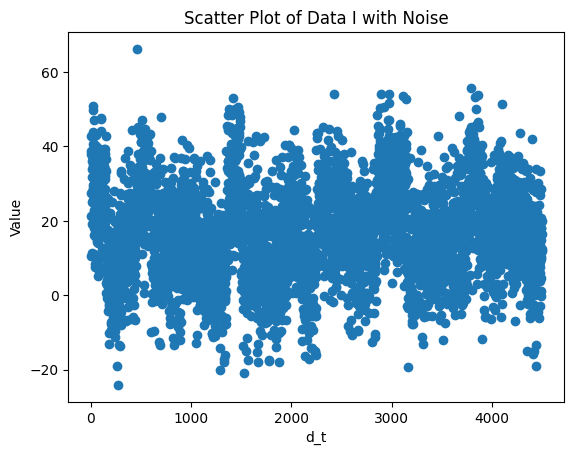

In [28]:
# Scatter Plot of Data

plt.scatter(range(len(Data_small_noise)), Data_small_noise)
plt.xlabel("d_t")
plt.ylabel("Value")
plt.title("Scatter Plot of Data I with Noise")
plt.show()

# plt.scatter(range(len(Data_2)), Data_2)
# plt.xlabel("d_t")
# plt.ylabel("Value")
# plt.title("Scatter Plot of Data II with Noise")
# plt.show()

Field-Level Estimation

In [30]:
# PM_converted = jnp.array(PM.toarray())

def model_func_1():
        s = numpyro.sample("s", dist.Uniform(low=jnp.full(N_r*N_p,-30), high=jnp.full(N_r*N_p,100)))
        # d = PM_converted @ s
        d = s[P_encoded]
        print(d.shape)
        d_noised = numpyro.sample("d_noised", dist.Normal(d,10.), obs=Data_small_noise)
        return d_noised

rng_key = random.PRNGKey(0)
nuts_kernel_1 = NUTS(model_func_1)
mcmc_1 = MCMC(nuts_kernel_1, num_warmup=100, num_samples=100)
mcmc_1.run(rng_key)

(4500,)
(4500,)
(4500,)


  0%|          | 0/200 [00:00<?, ?it/s]

(4500,)
(4500,)


sample: 100%|██████████| 200/200 [00:00<00:00, 447.27it/s, 7 steps of size 4.59e-01. acc. prob=0.90]


In [40]:
def model_func_2():
        s = numpyro.sample("s", dist.Uniform(low=jnp.full(N_r*N_p,0), high=jnp.full(N_r*N_p,100)))
        # d = PM_converted @ s
        d = s[P_encoded]
        print(d.shape)
        d_noised = numpyro.sample("d_noised", dist.Normal(d,10.), obs=Data_large_noise)
        return d_noised

rng_key = random.PRNGKey(0)
nuts_kernel_2 = NUTS(model_func_2)
mcmc_2 = MCMC(nuts_kernel_2, num_warmup=100, num_samples=100)
mcmc_2.run(rng_key)

(4500,)
(4500,)
(4500,)


  0%|          | 0/200 [00:00<?, ?it/s]

(4500,)
(4500,)


sample: 100%|██████████| 200/200 [00:00<00:00, 414.22it/s, 7 steps of size 4.21e-01. acc. prob=0.92]


In [41]:
trace_1 = az.from_numpyro(mcmc_1)
trace_2 = az.from_numpyro(mcmc_2)

(4500,)
(4500,)
(4500,)
(4500,)


In [42]:
trace_1.posterior['s'].squeeze().shape
trace_2.posterior['s'].squeeze().shape

(100, 30)

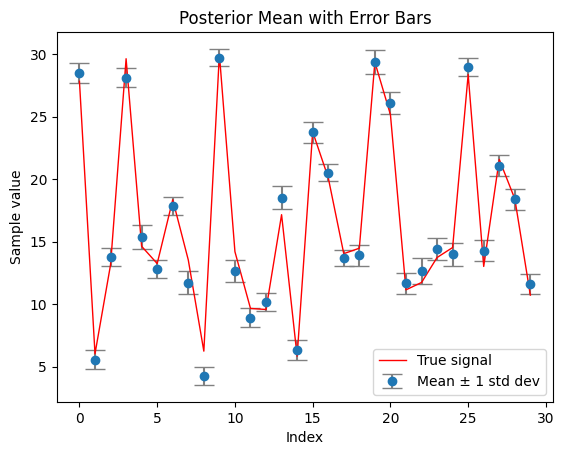

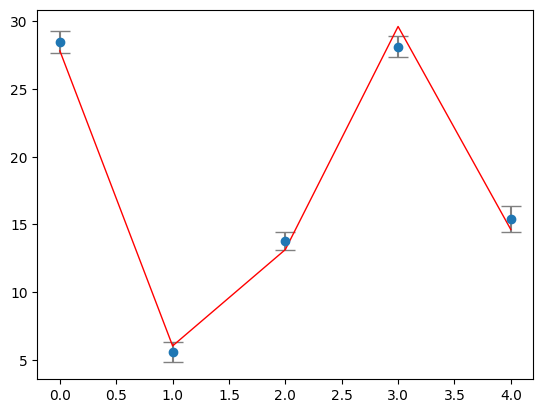

/var/folders/0b/tq5hs3nd30zcmpv164dvt6rc0000gn/T/ipykernel_23081/1028193603.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


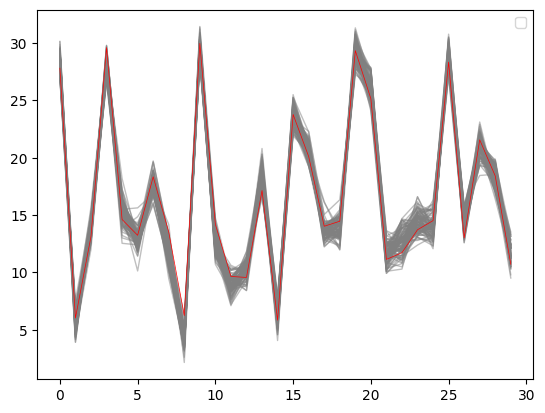

In [36]:
s_samples_1 = trace_1.posterior['s'].squeeze().values  # shape: (100, 25)
s_mean_1 = np.mean(s_samples_1, axis=0)                  # shape: (25,)
s_std_1 = np.std(s_samples_1, axis=0)                    # shape: (25,)

x = np.arange(len(s_mean_1))

plt.errorbar(x, s_mean_1, yerr=s_std_1, fmt='o', ecolor='gray', capsize=7,
             label='Mean ± 1 std dev')
plt.plot(signal, color='red', lw=1, label='True signal')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Sample value')
plt.title('Posterior Mean with Error Bars')
plt.show()

plt.errorbar(x[0:5], s_mean_1[0:5], yerr=s_std_1[0:5], fmt='o', ecolor='gray', capsize=7,
             label='Mean ± 1 std dev')
plt.plot(signal[0:5], color='red', lw=1, label='True signal')
plt.show()

for i in range(100):
    plt.plot(trace_1.posterior['s'].squeeze()[i,:], color='gray', alpha=0.5, lw=1.0)
    # plt.plot(trace.posterior['s'].squeeze()[i,:]-signal, color='blue', alpha=0.5, lw=1.0)
plt.plot(signal, color='red', lw=0.5)
plt.legend()
plt.show()

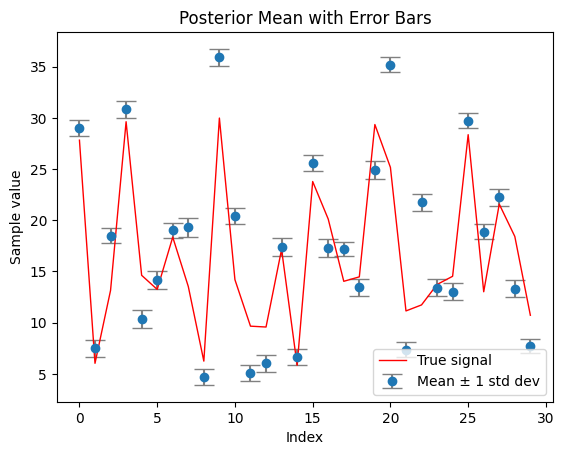

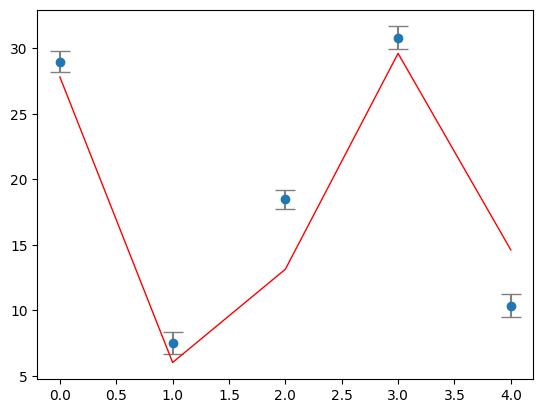

/var/folders/0b/tq5hs3nd30zcmpv164dvt6rc0000gn/T/ipykernel_23081/937641132.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


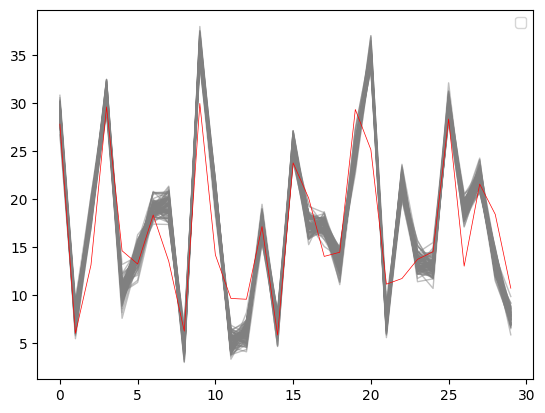

In [43]:
s_samples_2 = trace_2.posterior['s'].squeeze().values  # shape: (100, 25)
s_mean_2 = np.mean(s_samples_2, axis=0)                  # shape: (25,)
s_std_2 = np.std(s_samples_2, axis=0)                    # shape: (25,)

x = np.arange(len(s_mean_2))

plt.errorbar(x, s_mean_2, yerr=s_std_2, fmt='o', ecolor='gray', capsize=7,
             label='Mean ± 1 std dev')
plt.plot(signal, color='red', lw=1, label='True signal')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Sample value')
plt.title('Posterior Mean with Error Bars')
plt.show()

plt.errorbar(x[0:5], s_mean_2[0:5], yerr=s_std_2[0:5], fmt='o', ecolor='gray', capsize=7,
             label='Mean ± 1 std dev')
plt.plot(signal[:5], color='red', lw=1, label='True signal')
plt.show()

for i in range(100):
    plt.plot(trace_2.posterior['s'].squeeze()[i,:], color='gray', alpha=0.5, lw=1.0)
    # plt.plot(trace.posterior['s'].squeeze()[i,:]-signal, color='blue', alpha=0.5, lw=1.0)
plt.plot(signal, color='red', lw=0.5)
plt.legend()
plt.show()

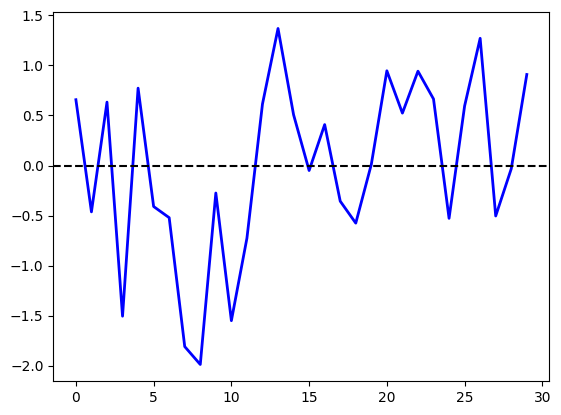

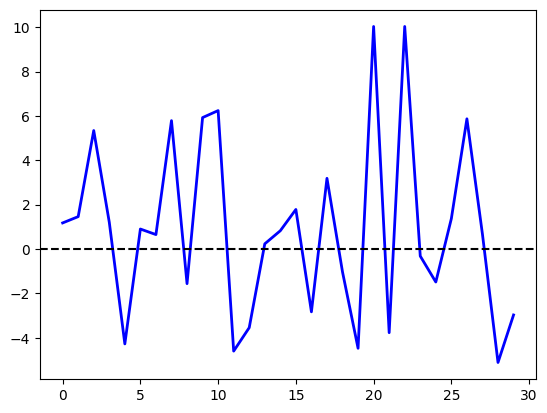

In [44]:
plt.plot(s_mean_1 - signal, color='blue', lw=2.0)
plt.axhline(0, color='black', linestyle='--')
plt.show()

plt.plot(s_mean_2 - signal, color='blue', lw=2.0)
plt.axhline(0, color='black', linestyle='--')
plt.show()